In [279]:
"""
from sklearn.datasets import fetch_openml
from sklearn import datasets, svm, metrics
from pandas import DataFrame
import matplotlib as mpl
"""

from typing import List, Tuple
from dataclasses import dataclass
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

import glob
import os
from pathlib import Path

# get nltk and corpus
import nltk
from nltk.corpus import stopwords

# get scapy and corpus
import spacy
import time
from functools import lru_cache

# Perform NLP analysis on Igor's Journal Entries
* https://spacy.io/
* https://www.nltk.org/

In [281]:
# This function is in the first block so you don't
# recreate it willy nilly, as it includes a cache.

nltk.download("stopwords")

# Remove domain words that don't help analysis.
# Should be factored out
domain_stop_words = set(
    """
    yes yup Affirmations get that's Journal
    Deliberate Disciplined Daily
    Know Essential Provide Context
    First Understand Appreciate
    """.lower().split()
)


@lru_cache(maxsize=4)
def get_nlp_model(model: str):
    start_time = time.time()
    print(f"Loading Model {model}")
    nlp = spacy.load(model)  # python -m spacy download en_core_web_lg
    spacy.prefer_gpu()  # This will be cool if/when it happens.
    duration = time.time() - start_time
    print(f"Took: {int(duration)}")
    return nlp


# Load corpus of my daily ramblings
@dataclass(frozen=True)
class Corpus:
    path: str
    all_content: str
    initial_words: List[str]
    words: List[str]

    def __hash__(self):
        return self.path.__hash__()


@lru_cache(maxsize=100)
def LoadCorpus(corpus_path: str) -> Corpus:

    # Hym consider memoizing this asweel..
    english_stop_words = set(stopwords.words("english"))
    all_stop_words = domain_stop_words | english_stop_words

    corpus_path_expanded = os.path.expanduser(corpus_path)
    corpus_files = glob.glob(corpus_path_expanded)

    """
    ######################################################
    # Performance side-bar.
    ######################################################

    A] Below code results in all strings Loaded into memory for temporary,  then merged into a second string.
    aka Memory = O(2*file_conent) and CPU O(2*file_content)

    B] An alternative is to do += on a string results in a new memory allocation and copy.
    aka Memory = O(file_content) , CPU O(files*file_content)

    However, this stuff needs to be measured, as it's also a funtion of GC. Not in the GC versions there is no change in CPU
    Eg.

    For A] if GC happens after every "join", then were down to O(file_content).
    For B] if no GC, then it's still O(2*file_content)
    """

    # Make single string from all the file contents.
    list_file_content = [Path(file_name).read_text() for file_name in corpus_files]
    all_file_content = " ".join(list_file_content)

    # NOTE I can Upper case Magic to make it a proper noun and see how it ranks!

    properNouns = "zach ammon Tori amelia josh Ray javier Neha Amazon John".split()

    def capitalizeProperNouns(s: str):
        for noun in properNouns:
            noun = noun.lower()
            properNoun = noun[0].upper() + noun[1:]
            s = s.replace(" " + noun, " " + properNoun)
        return s

    # Grr- Typo replacer needs to be lexically smart - sigh
    typos = [
        ("waht", "what"),
        ('I"ll', "I'll"),
        ("that", "that"),
        ("taht", "that"),
        ("ti ", " it "),
        ("that'sa", "that's a"),
        ("Undersatnd", "Understand"),
        ("Ill", "I'll"),
        ("Noitce", "Notice"),
        ("Whcih", "Which"),
        ("K ", "OK "),
        ("sTories", "stories"),
        ("htat", "that"),
        ("Getitng", "Getting"),
        ("Essenital", "Essential"),
        ("whcih", "which"),
    ]

    def fixTypos(s: str):
        for typo in typos:
            s = s.replace(" " + typo[0], " " + typo[1])
        return s

    all_file_content = fixTypos(all_file_content)
    all_file_content = capitalizeProperNouns(all_file_content)

    # Clean out some punctuation (although does that mess up stemming later??)
    initial_words = all_file_content.replace(",", " ").replace(".", " ").split()

    words = [word for word in initial_words if word.lower() not in all_stop_words]
    return Corpus(
        path=corpus_path,
        all_content=all_file_content,
        initial_words=initial_words,
        words=words,
    )


@lru_cache(maxsize=100)
def DocForCorpus(nlp, corpus: Corpus):
    print(
        f"initial words {len(corpus.initial_words)} remaining words {len(corpus.words)}"
    )
    print(f"Building corpus from {corpus.path} of len:{len(corpus.all_content)} ")
    start_time = time.time()
    # We use all_file_content not initial_words because we want to keep punctuation.
    doc_all = nlp(corpus.all_content)
    duration = time.time() - start_time

    # Remove domain specific stop words.
    doc = [token for token in doc_all if token.text.lower() not in domain_stop_words]
    print(f"Took: {int(duration)}")
    return doc

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


# Build corpus from my journal in igor2/750words 

In [282]:
# make function path for y/m

def glob750(year, month):
    assert month in range(1, 13)
    base750 = "~/gits/igor2/750words/"
    return f"{base750}/{year}-{month:02}-*.md"


def glob750archive(year, month):
    assert month in range(1, 13)
    base750archive = "~/gits/igor2/750words_archive/"
    return f"{base750archive}/750 Words-export-{year}-{month:02}-01.txt"


def corpus_paths_months_for_year(year):
    return [glob750archive(year, month) for month in range(1, 13)]


# Use normal method for 2012-2017
corpus_path_months = {
    year: corpus_paths_months_for_year(year) for year in range(2012, 2018)
}

# 2018  changes from archive to markdown.
# 2018 Jan/Feb/October don't have enough data for analysis
corpus_path_months[2018] = [glob750archive(2018, month) for month in range(3, 8)] + [
    glob750(2018, month) for month in (9, 11, 12)
]

corpus_path_months[2019] = [glob750(2019, month) for month in range(1, 7)]

corpus_paths_months_trailing = [
    glob750(2018, month) for month in (9, 11, 12)
] + corpus_path_months[2019]

corpus_paths_years = [
    "~/gits/igor2/750words_archive/*2012*txt",
    "~/gits/igor2/750words_archive/*2013*txt",
    "~/gits/igor2/750words_archive/*2014*txt",
    "~/gits/igor2/750words_archive/*2015*txt",
    "~/gits/igor2/750words_archive/*2016*txt",
    "~/gits/igor2/750words_archive/*2017*txt",
    "~/gits/igor2/750words_archive/*2018*txt",
    "~/gits/igor2/750words/2018*md",
    "~/gits/igor2/750words/2019-*md",
]

# TODO: Add a pass to remove things with insufficient words.


In [274]:
# make the plot wider
height_in_inches = 8
matplotlib.rc("figure", figsize=(2 * height_in_inches, height_in_inches))

### Load simple corpus for my journal

In [283]:
corpus = LoadCorpus(corpus_paths_months_2019[0])
print(f"initial words {len(corpus.initial_words)} remaining words {len(corpus.words)}")

initial words 17339 remaining words 8535


In [284]:
# Could use nltk frequency distribution plot, but better off building our own.
# fd = nltk.FreqDist(words)
# fd.plot(50, percents=True)
# Can also use scikit learn CountVectorizor

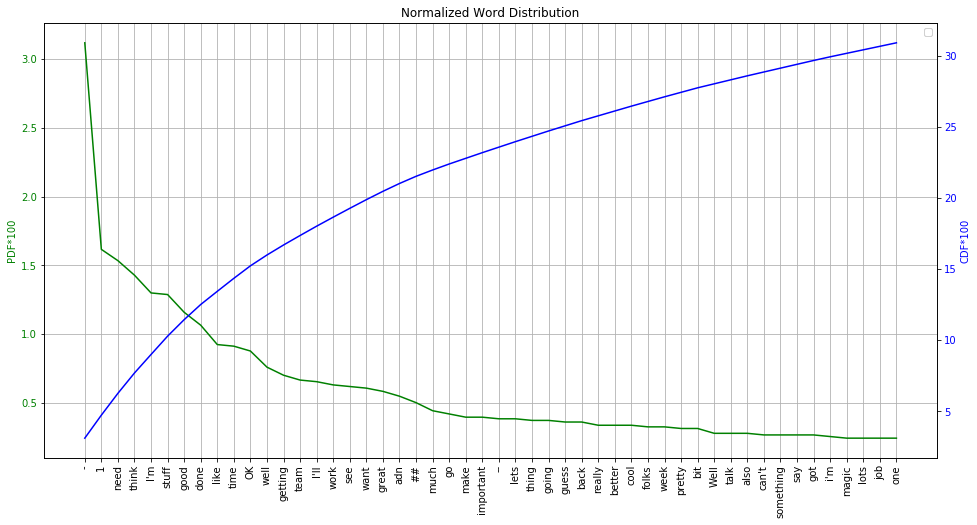

In [286]:
# Same as NLTK FreqDist, except normalized, includes cumsum, and colors
def GraphWordDistribution(words, title="", skip=0, length=50, includeCDF=True) -> None:
    def GetPDFCDF(words):
        def ToPercent(x: float) -> float:
            return x * 100

        # NOTE: No point creating a full data frame when only using a single column.
        pdf = pd.Series(words).value_counts(normalize=True).apply(ToPercent)
        cdf = pdf.cumsum()
        return (pdf, cdf)

    def PlotOnAxis(series, ax, label: str, color: str):
        # RANT: Why is MPL so confusing? The OO interface vs the stateful interface, GRAH!!
        # The random non-obvious calls.
        # GRAH!!!

        ax.legend(label.split())
        ax.plot(series, color=color)

        # RANT: Why no YAxis.set_labal_params()? E.g.
        #                 ax.yaxis.set_label_params(label, color=color)
        ax.set_ylabel(label, color=color)
        ax.yaxis.set_tick_params(labelcolor=color)

        # technically all the X axis paramaters are duplicated since we "twinned the X paramater"
        ax.xticks = range(len(series))

        # RANT: rot can be set on plt.plot(), but not on axes.plot()
        ax.xaxis.set_tick_params(rotation=90)

    # NOTE: can make graph prettier with styles E.g.
    # with plt.style.context("ggplot"):
    fig, ax = plt.subplots(1)

    ax.set_title(title)
    ax.grid(True)

    # make pdf first axes, and cdf second axes.
    ax_pdf, ax_cdf = (ax, ax.twinx())
    color_pdf, color_cdf = ("green", "blue")
    pdf, cdf = GetPDFCDF(words)

    PlotOnAxis(pdf[skip : skip + length], ax_pdf, label="PDF*100", color=color_pdf)
    PlotOnAxis(cdf[skip : skip + length], ax_cdf, label="CDF*100", color=color_cdf)


GraphWordDistribution(corpus.words, title="Normalized Word Distribution")

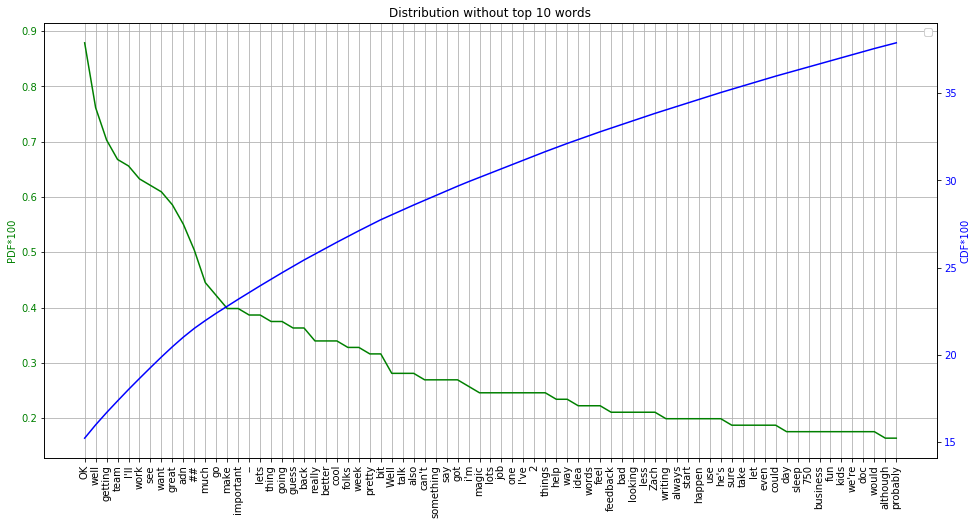

In [287]:
skip = 10
GraphWordDistribution(
    corpus.words, skip=skip, length=75, title=f"Distribution without top {skip} words"
)

In [184]:
# wordcloud is non-deterministic, which is bizarre.
# from wordcloud import WordCloud
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=None).generate("".join(words))
# plt.imshow(wordcloud,  interpolation='bilinear')

# Play with POS tagging and lemmatisation

In [288]:
nlp = get_nlp_model("en_core_web_lg")
nlp.max_length = 100 * 1000 * 1000

def GetInterestingWords(pos: str, doc, corpus: Corpus):
    interesting_pos = pos
    interesting_pos_set = set(interesting_pos.split())
    interesting = [token for token in doc if token.pos_ in interesting_pos_set]
    interesting_words = [token.lemma_ for token in interesting]
    return interesting_words


def GraphPoSForDoc(pos: str, doc, corpus):
    GraphWordDistribution(
        GetInterestingWords(pos, doc, corpus=corpus),
        title=f"Distribution of {pos} on {corpus.path}",
        skip=0,
        length=20,
    )


def GraphScratchForCorpus(corpus_path: str, pos: str = "NOUN VERB ADJ ADV"):
    corpus = LoadCorpus(corpus_path)
    doc = DocForCorpus(nlp, corpus)
    GraphPoSForDoc(pos, doc, corpus)


def GetInterestingForCorpusPath(corpus_path: str, pos: str = "NOUN VERB ADJ ADV"):
    corpus = LoadCorpus(corpus_path)
    doc = DocForCorpus(nlp, corpus)
    return GetInterestingWords(pos, doc, corpus)

Loading Model en_core_web_lg
Took: 11


In [289]:
# corpus_paths = corpus_paths_years
corpus_paths = corpus_path_months[2016]
print(corpus_paths)

['~/gits/igor2/750words_archive//750 Words-export-2016-01-01.txt', '~/gits/igor2/750words_archive//750 Words-export-2016-02-01.txt', '~/gits/igor2/750words_archive//750 Words-export-2016-03-01.txt', '~/gits/igor2/750words_archive//750 Words-export-2016-04-01.txt', '~/gits/igor2/750words_archive//750 Words-export-2016-05-01.txt', '~/gits/igor2/750words_archive//750 Words-export-2016-06-01.txt', '~/gits/igor2/750words_archive//750 Words-export-2016-07-01.txt', '~/gits/igor2/750words_archive//750 Words-export-2016-08-01.txt', '~/gits/igor2/750words_archive//750 Words-export-2016-09-01.txt', '~/gits/igor2/750words_archive//750 Words-export-2016-10-01.txt', '~/gits/igor2/750words_archive//750 Words-export-2016-11-01.txt', '~/gits/igor2/750words_archive//750 Words-export-2016-12-01.txt']


initial words 17489 remaining words 8610
Building corpus from ~/gits/igor2/750words_archive//750 Words-export-2016-01-01.txt of len:91252 
Took: 3
initial words 12420 remaining words 6317
Building corpus from ~/gits/igor2/750words_archive//750 Words-export-2016-02-01.txt of len:64794 
Took: 2
initial words 13986 remaining words 7056
Building corpus from ~/gits/igor2/750words_archive//750 Words-export-2016-03-01.txt of len:71658 
Took: 2
initial words 1560 remaining words 814
Building corpus from ~/gits/igor2/750words_archive//750 Words-export-2016-04-01.txt of len:7980 
Took: 0
initial words 4709 remaining words 2355
Building corpus from ~/gits/igor2/750words_archive//750 Words-export-2016-05-01.txt of len:24175 
Took: 0
initial words 2311 remaining words 1107
Building corpus from ~/gits/igor2/750words_archive//750 Words-export-2016-06-01.txt of len:11783 
Took: 0
initial words 3914 remaining words 2029
Building corpus from ~/gits/igor2/750words_archive//750 Words-export-2016-07-01.txt

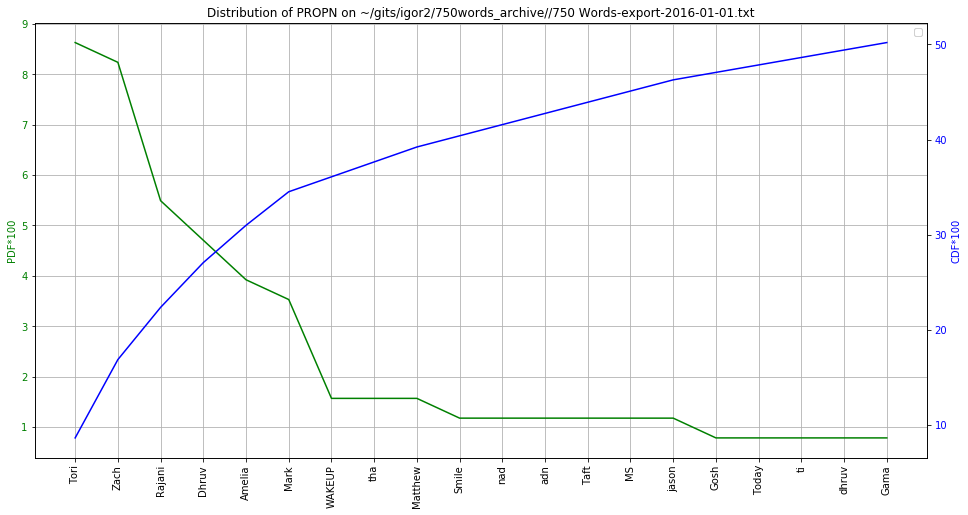

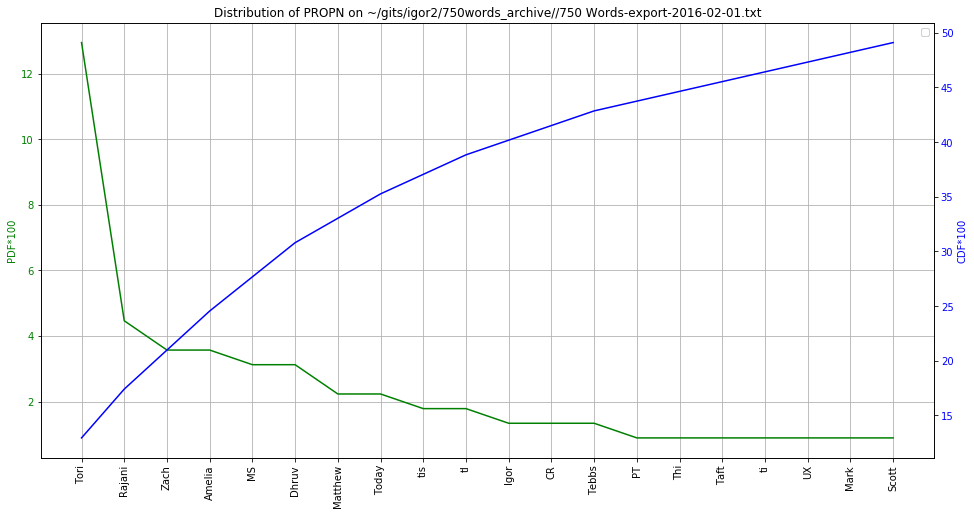

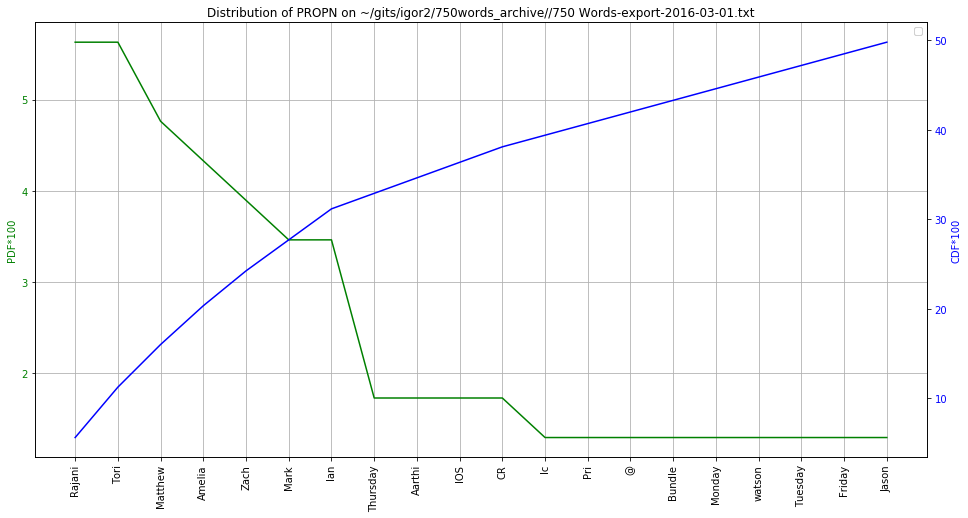

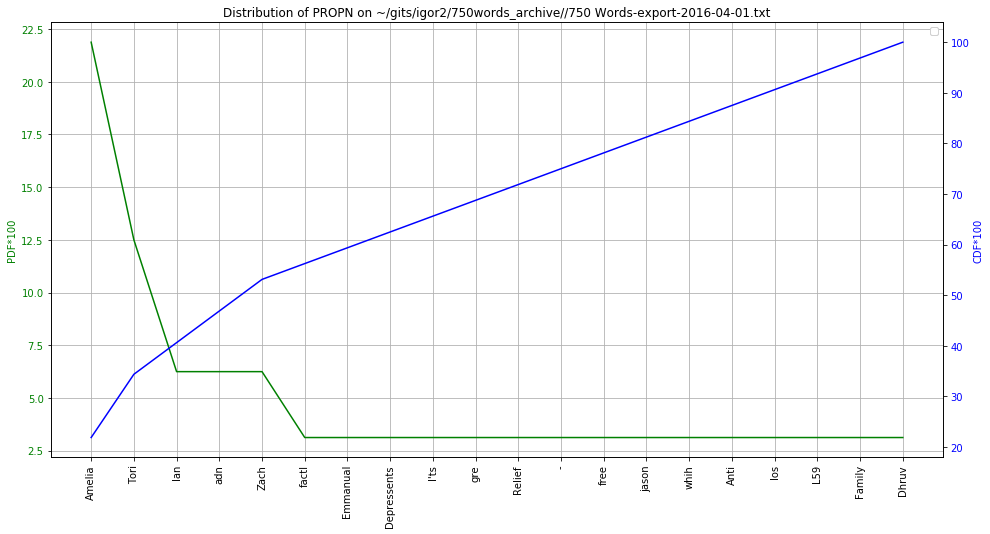

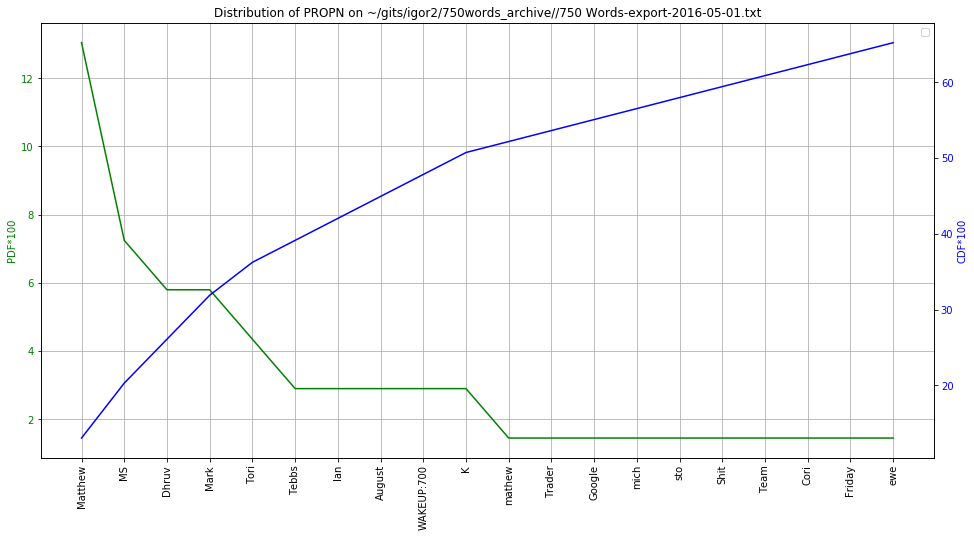

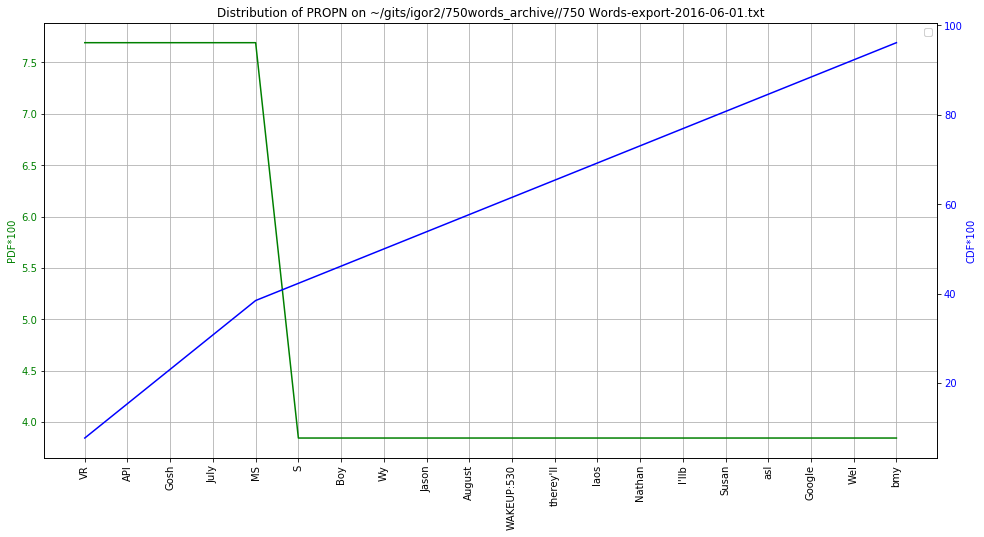

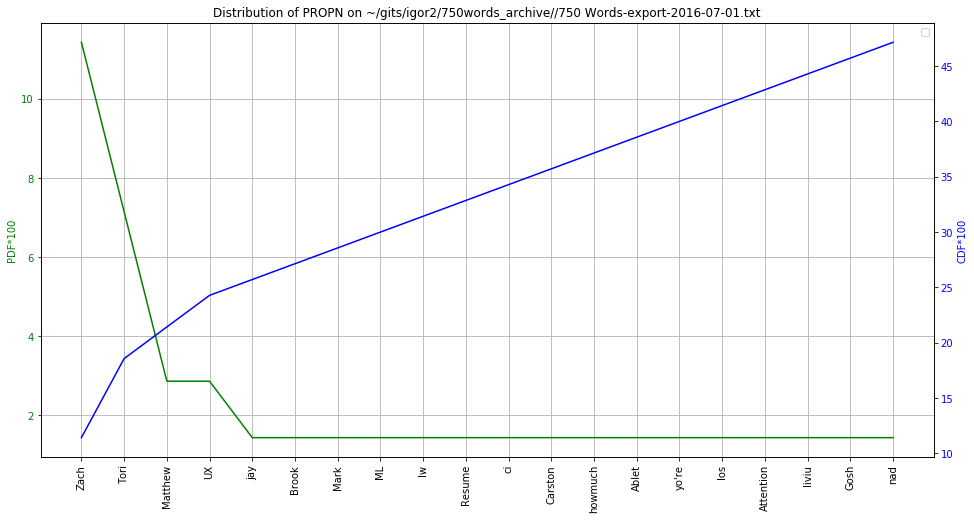

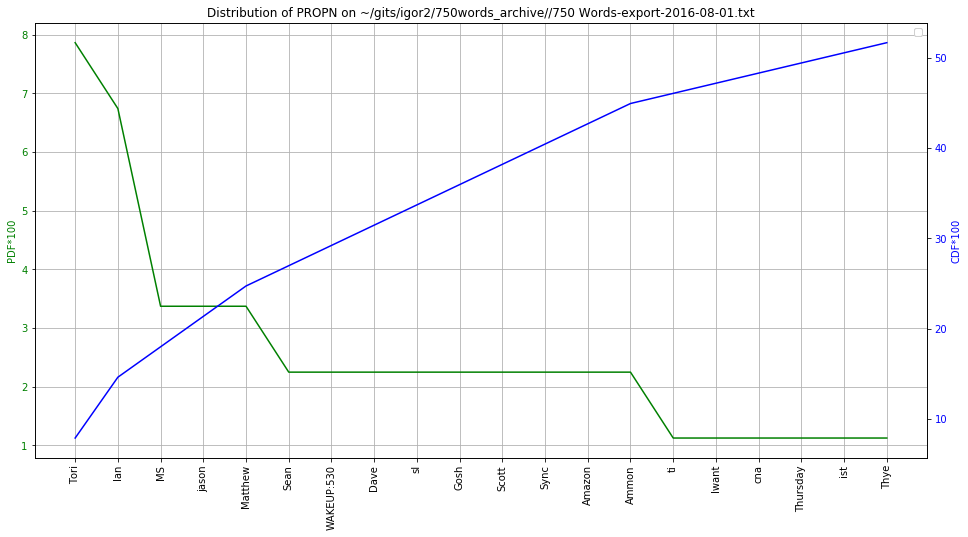

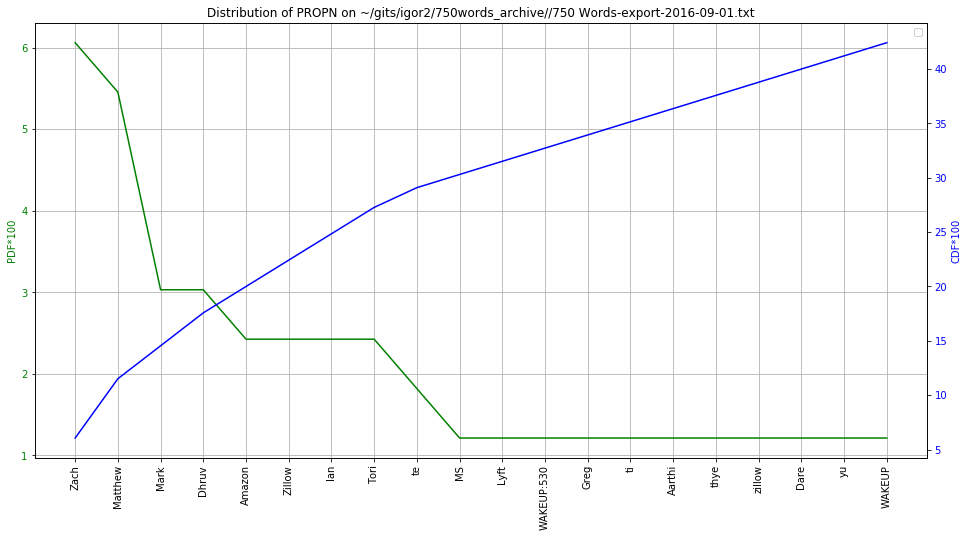

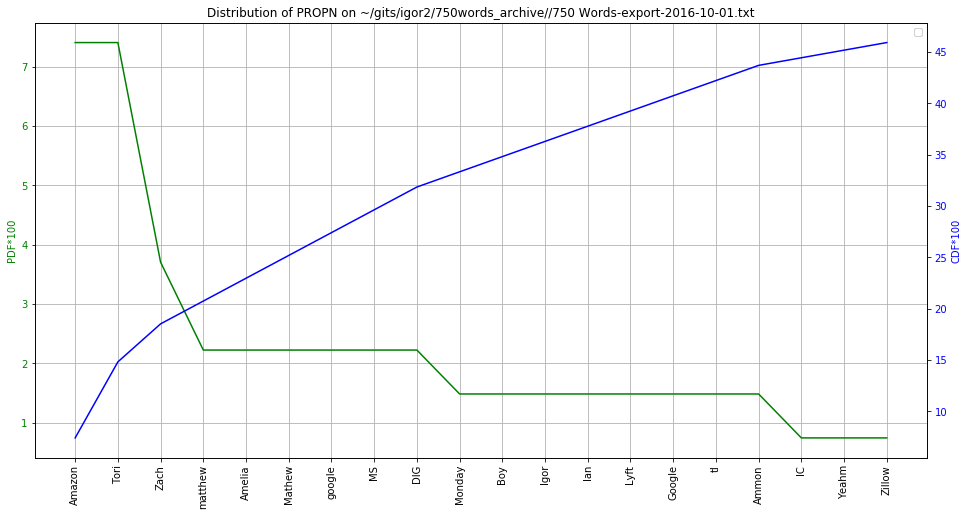

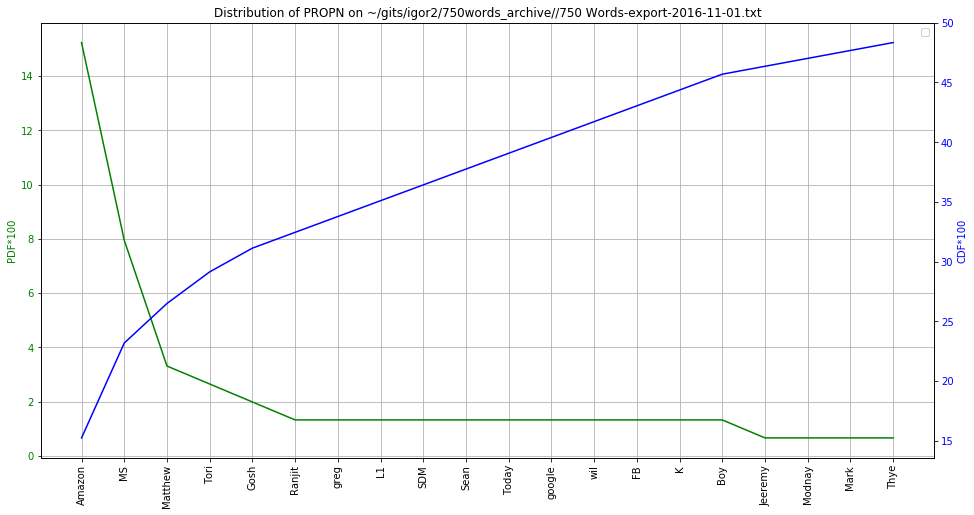

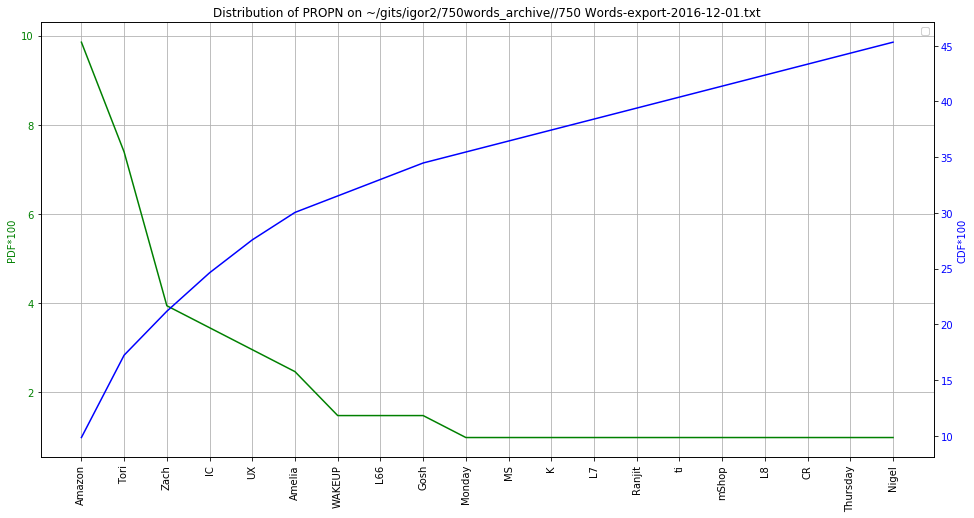

In [290]:
for c in corpus_paths:
    GraphScratchForCorpus(c, pos="PROPN")

# Debugging when stuff goes goofy.

In [237]:
_ = """
max_to_analyze = 15
interesting = [token for token in doc if token.tag_ == "NNS"]
for token in interesting[:max_to_analyze]:
    # print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop)
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_)

# Parts of speech: https://spacy.io/usage/linguistic-features
GraphWordDistribution([token.pos_ for token in doc], title=f"POS Distribution on {corpus_path}")
# interesting = [ token for token in doc if token.pos_ != "PUNCT" and token.pos_ != "SYM" and len(token.text) > 3]
"""

### Visualizing the "Thought Distribution" over time.
* A] Sentiment over time. Graph valence as line graph time series 
    (TBD: Use cloud service to analyze each file)

* B] Graph a bar chart of Proper noun trending over time, have it update per corpus file.
 * Build a data frame of word frequency "Proper Noun"x"Corpus"
 * Graph update every second.

In [291]:
def MakePDF(words, name):
    def ToPercent(x: float) -> float:
        return x * 100

    return pd.Series(words, name=name).value_counts(normalize=True).apply(ToPercent)


def PathToFriendlyTitle(path: str):
    path = path.split("/")[-1]
    if "export-" in path:
        return path.split("export-")[-1]
    else:
        return path

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1d4398cc0>,
      dtype=object)

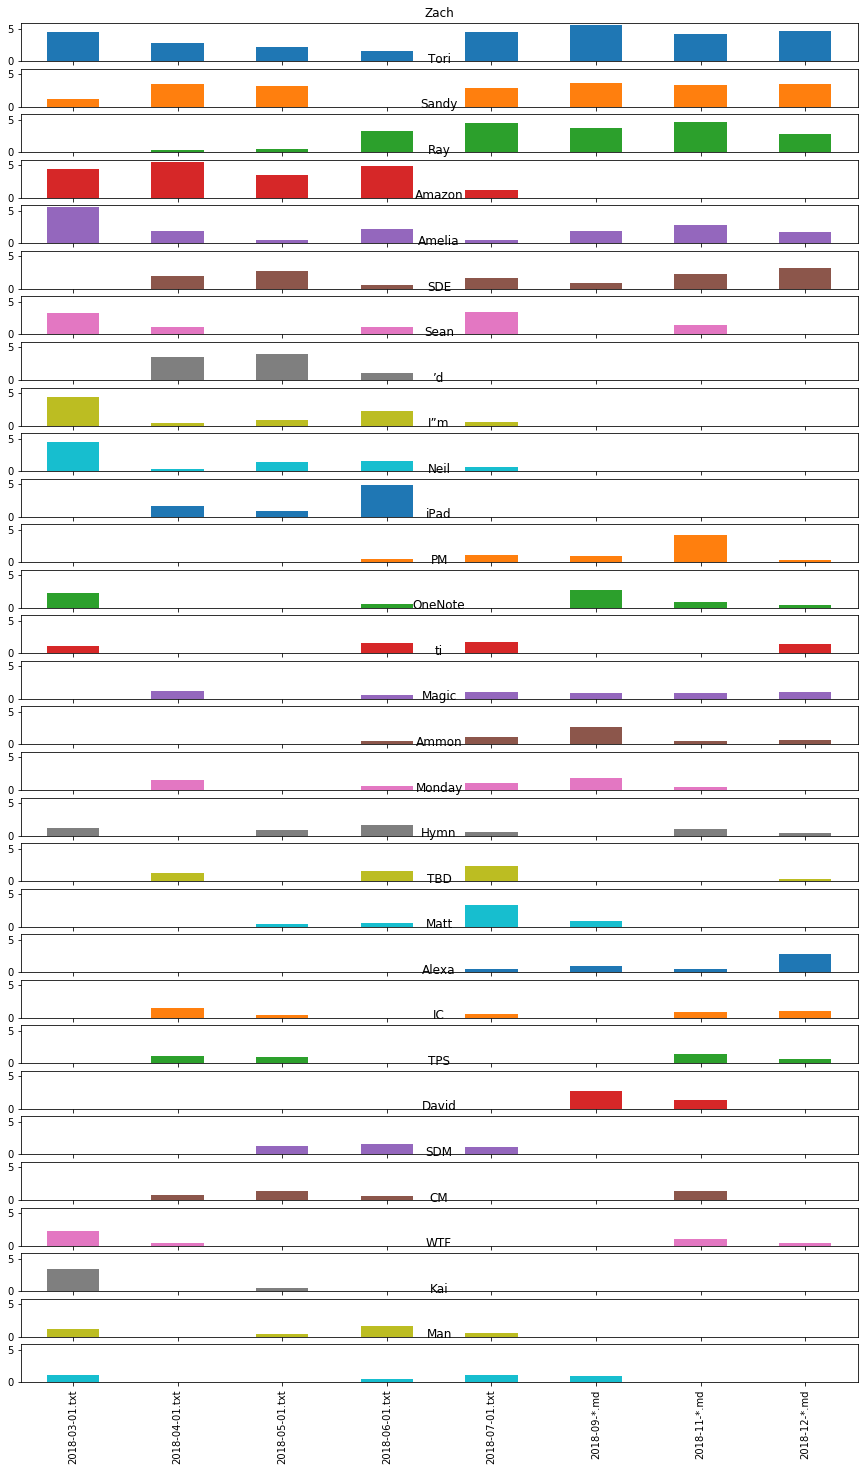

In [301]:
# corpus_paths = corpus_path_months[2018]+corpus_path_months[2019]
corpus_paths = corpus_path_months[2018]
pdfs = [
    MakePDF(GetInterestingForCorpusPath(p, "PROPN"), PathToFriendlyTitle(p))
    for p in corpus_paths
]

# TODO: Why can't we use the join - gives an error.
# wordByTimespan = pd.DataFrame().join(pdfs, how="outer", sort=False)
wordByTimespan = pd.DataFrame()
for pdf in pdfs:
    wordByTimespan = wordByTimespan.join(pdf, how="outer")

# Sort by sum(word frequency) over all corpus 
# I  suspect it'd be interesting to sort by TF*IDF because it'll make words that are present 
# only in a few months get a boost.
wordByTimespan["word_frequency"] = wordByTimespan.sum(skipna=True, axis="columns")
wordByTimespan = wordByTimespan.sort_values("word_frequency", ascending=False)

# Remove total column
wordByTimespan = wordByTimespan.iloc[:, :-1]

#wordByTimespan.iloc[:50, :].plot( kind="bar", subplots=False, legend=False, figsize=(15, 14), sharey=True )
wordByTimespan.iloc[:30, :].T.plot( kind="bar", subplots=True, legend=False, figsize=(15, 25), sharey=True )
# wordByTimespan.iloc[:13, :].T.plot( kind="bar", subplots=False, legend=True, figsize=(15, 14), sharey=True )

In [293]:
demo = """
corpus_path = "~/gits/igor2/750words/2019-06-*md"
corpus = LoadCorpus(corpus_path)
doc = DocForCorpus(nlp, corpus)
for t in doc[400:600]:
print(f"{t} {t.lemma_} {t.pos_}")
"""

for for ADP
me -PRON- PRON
to to PART
help help NOUN
from from ADP
, , PUNCT
having have VERB
other other ADJ
teams team NOUN
lets let VERB
me -PRON- PRON
borrow borrow VERB
- - PUNCT
which which DET
I -PRON- PRON
guess guess VERB
we -PRON- PRON
did do VERB
from from ADP
Bob Bob PROPN
, , PUNCT
that that DET
was be VERB
great great ADJ
, , PUNCT
but but CCONJ
at at ADP
the the DET
end end NOUN
of of ADP
the the DET
day day NOUN
that that DET
s s VERB
brutal brutal ADJ
. . PUNCT


 

 SPACE
So so ADV
, , PUNCT
the the DET
consequence consequence NOUN
here here ADV
I -PRON- PRON
'm be VERB
worried worried ADJ
about about ADP
- - PUNCT
there there ADV
really really ADV
is be VERB
n't not ADV
a a DET
consequence consequence NOUN
here here ADV
- - PUNCT
will will VERB
my -PRON- DET
review review NOUN
be be VERB
brutal brutal ADJ
- - PUNCT
perhaps perhaps ADV
, , PUNCT
but but CCONJ
that that DET
's be VERB
an an DET
interesting interesting ADJ
question question NOUN
- - PUNCT
certianly cert